In [1]:
#Introduction

#.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [2]:
import sys
sys.executable
#!which python #which does not semm to work on windows

'C:\\Users\\moritz\\anaconda3\\envs\\social-2\\python.exe'

# Install dependencies:

In [3]:
install_packages = False
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge html2text -y
    !conda install -c conda-forge tensorflow-hub -y # !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y
    print("Done")

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\moritz\anaconda3\envs\social-2

  added / updated specs:
    - tensorflow=2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.10.14 |                0         122 KB
    openssl-1.1.1h             |       he774522_0         4.8 MB
    ------------------------------------------------------------
                                           Total:         5.0 MB

The following packages will be UPDATED:

  certifi                anaconda::certifi-2020.6.20-py36_0 --> pkgs/main::certifi-2020.11.8-py36haa95532_0

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates                                  anaconda --> pkgs/main
  openssl                                          anaconda --> pkgs/main




openssl-1.1.1h       | 4.8 MB    |            | 

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # conda install html2text


Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\moritz\anaconda3\envs\social-2

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1h             |       he774522_0         5.8 MB  anaconda
    ------------------------------------------------------------
                                           Total:         5.8 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2020.11.~ --> anaconda::ca-certificates-2020.10.14-0
  certifi            conda-forge::certifi-2020.11.8-py36ha~ --> anaconda::certifi-2020.6.20-py36_0
  openssl                                       conda-forge --> anaconda




openssl-1.1.1h       | 5.8 MB    |      

# Imports

In [4]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [6]:
data_path = './data/videoinfo_VMXcbWwzeY8_2020_11_24-15_26_42_comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [7]:
try:
   os.mkdir(output_path)
except OSError:
  print ("Creation of the directory %s failed" % output_path)
else:
  print ("Successfully created the directory %s " % output_path)


Successfully created the directory ./output/ 


# Load Data
Load you data as a pandas dataframe

In [8]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [9]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [10]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

100%|███████████████████████████████████████████████████████████████████████████| 1520/1520 [00:00<00:00, 11286.85it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [11]:
if new_embeddings:
  data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
  data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-11-21 01:19:26,GS Railfann,Climate is fake,0,Climate is fake\n\n
1,2020-11-14 21:25:35,Rajat Baniya,Lol..,0,Lol..\n\n
2,2020-11-14 14:33:33,Syria Siri,"The poor countries on this planet no climate change is real , The rich deny it because of money , As usual the poor with nothing who live simple lives suffer in this Life , i am sure it will be the other way around in the next life ?",0,"The poor countries on this planet no climate change is real , The rich deny it\nbecause of money , As usual the poor with nothing who live simple lives suffer\nin this Life , i am sure it will be the other way around in the next life ?\n\n"
3,2020-11-04 16:18:39,Catface Toons,Trump said global warming was a hoax just look at the ice caps tell that to the folks,0,Trump said global warming was a hoax just look at the ice caps tell that to\nthe folks\n\n
4,2020-10-31 22:15:38,Tim Popik,Why was it that California was not taking care of the forests? - zero forest management. Nature&#39;s way to manage forests is FIRE,0,Why was it that California was not taking care of the forests? - zero forest\nmanagement. Nature's way to manage forests is FIRE\n\n


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [12]:
hub_url = url_dict[model_type]
if new_embeddings:
  print("Loading model. This will take some time...")
  embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [13]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 4 5 6 7 The embeddings vector is of fixed length 512


TensorShape([1520, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.          0.08336148  0.3147695  ...  0.15701678  0.43515855
   0.20181644]
 [ 0.08336148  1.         -0.03067182 ...  0.20465687 -0.01571003
   0.14301391]
 [ 0.3147695  -0.03067182  1.         ...  0.03741583  0.40591344
   0.04954696]
 ...
 [ 0.15701678  0.20465687  0.03741583 ...  0.99999994 -0.00946979
   0.17928067]
 [ 0.43515855 -0.01571003  0.40591344 ... -0.00946979  1.0000001
   0.0582822 ]
 [ 0.20181644  0.14301391  0.04954696 ...  0.17928067  0.0582822
   1.0000001 ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

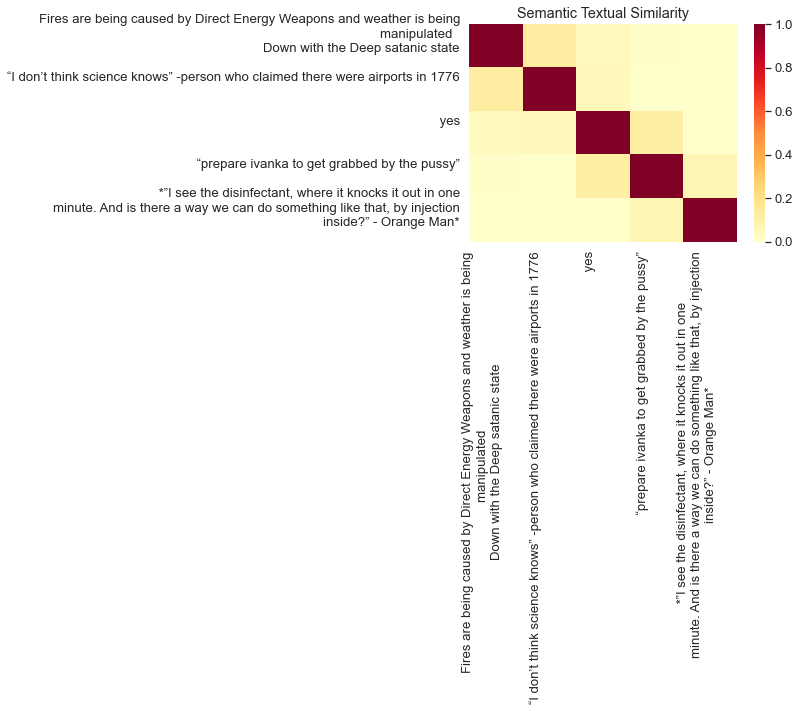

In [25]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0,
      vmax=1,
      cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 170

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [26]:
comment_index = 171
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

“I don’t think science knows” -person who claimed there were airports in 1776




Print similar comments.

In [27]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 20)):
  print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: “I don’t think science knows” -person who claimed there were airports in 1776


Top similar comment 2: "I don't think science knows, actually"  
~Donald Trump


Top similar comment 3: Nobody knows more about science, than Trump.


Top similar comment 4: Imagine actually believing some guy that said science doesn’t know what it’s
talking about, instead of 99.7% of all scientists.🤦🏻


Top similar comment 5: "I don't think science knows"\- D. Trump.


Top similar comment 6: Did the guy just say "I don't think science know, actually"???


Top similar comment 7: @ science doesn't know that this is an arson


Top similar comment 8: "I dOnT ThInK sCiEnCe kNoWs aCtUaLlY"  
I'm surprised he's not an anti vaxxer/ flat earther


Top similar comment 9: "I don't think Science knows." Truest words Trump ever spoke. Down with the
mandated religion of Scientificism!


Top similar comment 10: The Science clearly doesn't know because the fires don't go into the Canadian
or Mexican